# CS 363D Final Project: Predicting Adoption in Austin Animal Center

#### Mrityunjay Mishra, Rohit Neppalli, Ziyi Zhao, Justin Leong 

## Project Description

Many different types of animals (from dogs to livestock) are taken in by the Austin Animal Center each year for various reasons. Some may be adopted, some may be transferred, and some may even go through Euthanasia. The goal of this project is to predict if an animal that is taken in by the Austin Animal Center will be adopted or not. This can have good applications for Austin Animal Center - they could use our findings to predict the probability of adoption for an animal that is taken in and can care for it accordingly. Or perhaps someone else can use our findings to find animals who have a low probability of adoption to care for them accordingly. In the end, we hope that our findings provide insight into the adoption patterns of Austin and, consequently, helps different organizations take care of these animal appropriately.

In [1]:
# importing headers
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

# Enable inline mode for matplotlib so that IPython displays graphs.
%matplotlib inline

## Dataset

To develop our classifier(s), we use the animal intake and outcome data from the open data portal of the city of Austin. To find out more about the animal intake data, [click here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm). To find out more about the outcome data, [click here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238). 

In [2]:
# Intakes data
intakes_df = pd.read_csv('Austin_Animal_Center_Intakes.csv')
intakes_df.head()

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
0,A786884,*Brock,01/03/2019 04:19:00 PM,January 2019,2501 Magin Meadow Dr in Austin (TX),Stray,Normal,Dog,Neutered Male,2 years,Beagle Mix,Tricolor
1,A706918,Belle,07/05/2015 12:59:00 PM,July 2015,9409 Bluegrass Dr in Austin (TX),Stray,Normal,Dog,Spayed Female,8 years,English Springer Spaniel,White/Liver
2,A724273,Runster,04/14/2016 06:43:00 PM,April 2016,2818 Palomino Trail in Austin (TX),Stray,Normal,Dog,Intact Male,11 months,Basenji Mix,Sable/White
3,A665644,NaN,10/21/2013 07:59:00 AM,October 2013,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico
4,A682524,Rio,06/29/2014 10:38:00 AM,June 2014,800 Grove Blvd in Austin (TX),Stray,Normal,Dog,Neutered Male,4 years,Doberman Pinsch/Australian Cattle Dog,Tan/Gray


In [3]:
# Outcomes data
outcomes_df = pd.read_csv('Austin_Animal_Center_Outcomes.csv')
outcomes_df.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,05/08/2019 06:20:00 PM,May 2019,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,07/18/2018 04:02:00 PM,Jul 2018,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,08/16/2020 11:38:00 AM,Aug 2020,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,02/13/2016 05:59:00 PM,Feb 2016,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,NaN,03/18/2014 11:47:00 AM,Mar 2014,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


## Data Cleaning

We can immedietly see that we must combine both `intakes_df` and `outcomes_df` on `Animal ID`. We will first explore and clean both `intakes_df` and `outcomes_df` and combine them in the end.

### Feature Selection

`Name`, `DateTime`, `MonthYear`, and `Found Location` can immedietly be dropped from `intakes_df` because these features will not have be be relevant to determining if an animal will be adopted or not. The name of the animal could be changed after adoption; `DateTime` and `MonthYear` are related to `Age upon Intake` and thus irrelevant (because age is more important than the exact date etc.); and `Found Location` is also irrelevant in adoption matters. 

We may think that `Intake Type` can also be dropped. However, it actually has some useful values that may determine adoption or not. 

In [4]:
intakes_df['Intake Type'].unique()

array(['Stray', 'Owner Surrender', 'Public Assist', 'Wildlife',
       'Euthanasia Request', 'Abandoned'], dtype=object)

Clearly, if an animal is taken into Austin Animal Center on a Euthanasia Request, then its chances for being adopted become drastically low. Other reasons for intake can also play a part in adoption considerations. Therefore, we do not drop `Intake Type`. The final columns that are dropped from `intakes_df` are `Name`, `DateTime`, `MonthYear`, `Found Location`.

In [5]:
intakes_df = intakes_df.drop(columns=['Name', 'DateTime', 'MonthYear', 'Found Location'])
intakes_df.head()

,Animal ID,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
0,A786884,Stray,Normal,Dog,Neutered Male,2 years,Beagle Mix,Tricolor
1,A706918,Stray,Normal,Dog,Spayed Female,8 years,English Springer Spaniel,White/Liver
2,A724273,Stray,Normal,Dog,Intact Male,11 months,Basenji Mix,Sable/White
3,A665644,Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico
4,A682524,Stray,Normal,Dog,Neutered Male,4 years,Doberman Pinsch/Australian Cattle Dog,Tan/Gray


Similarly, `Name`, `DateTime`, `Date of Birth`, and `Outcome Subtype` can immedietly be dropped from `outcomes_df` because there features will not be relevant to classification. Once again, `Name` is clearly irrelevant; the `DateTime` of the outcome makes no difference as to what the outcome is; the `Date of Birth` of the animal is related to its `Age upon Outcome` and thus is not important; and we are not interested in `Outcome Subtype` at the moment. We decided to keep `MonthYear` because it is possible that animals (or some types of animals) are adopted more at certain times of the year (e.x. Christmas) than others. `outcomes_ds` after removing these features is as follows.

In [6]:
outcomes_df = outcomes_df.drop(columns=['Name', 'DateTime', 'Date of Birth', 'Outcome Subtype'])
outcomes_df.head()

,Animal ID,MonthYear,Outcome Type,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,May 2019,Rto-Adopt,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Jul 2018,Adoption,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,Aug 2020,Euthanasia,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Feb 2016,Adoption,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,Mar 2014,Transfer,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


### Removing missing and erroneous values

As can be seen below, some values are missing from some rows in both `intakes_df` and `outcomes_df`. However, this is not a significant number of rows, so we just drop these rows. 

In [7]:
# Notice that the total row count per feature in both intakes_df 
# and outcomes_df is not the same, indicating that some values 
# are missing from the both datasets
print('Total number of rows in intakes_df: {:d}\n'.format(intakes_df.shape[0]))
print('Number of non-NaN rows (or rows without missing values in general) in intakes_df')
print(intakes_df.count()) 

print('\nTotal number of rows in intakes_df: {:d}\n'.format(outcomes_df.shape[0]))
print('Number of non-NaN rows (or rows without missing values in general) in outcomes_df')
print(outcomes_df.count()) 

Total number of rows in intakes_df: 138350

Number of non-NaN rows (or rows without missing values in general) in intakes_df
Animal ID           138350
Intake Type         138350
Intake Condition    138350
Animal Type         138350
Sex upon Intake     138349
Age upon Intake     138350
Breed               138350
Color               138350
dtype: int64

Total number of rows in intakes_df: 138565

Number of non-NaN rows (or rows without missing values in general) in outcomes_df
Animal ID           138565
MonthYear           138565
Outcome Type        138542
Animal Type         138565
Sex upon Outcome    138564
Age upon Outcome    138559
Breed               138565
Color               138565
dtype: int64


In [8]:
intakes_df.dropna(inplace=True)
outcomes_df.dropna(inplace=True)

We also notice that there are some erroneous values for `Age upon Intake` and `Age upon Outcome` in the `intakes_df` and `outcomes_df`. Thus, we drop these rows (we do not try to rectify such values so as to not skew the data or introduce any other type of bias).

In [9]:
print('Unique values of Age upon Intake')
print(intakes_df['Age upon Intake'].unique())
print()
print('Unique values of Age upon Outcome')
print(outcomes_df['Age upon Outcome'].unique())

Unique values of Age upon Intake
['2 years' '8 years' '11 months' '4 weeks' '4 years' '6 years' '6 months'
 '5 months' '14 years' '1 month' '2 months' '18 years' '9 years'
 '4 months' '1 year' '3 years' '4 days' '1 day' '5 years' '2 weeks'
 '15 years' '7 years' '3 weeks' '3 months' '12 years' '1 week' '9 months'
 '10 years' '10 months' '7 months' '8 months' '1 weeks' '5 days' '0 years'
 '2 days' '11 years' '17 years' '3 days' '13 years' '5 weeks' '19 years'
 '6 days' '16 years' '20 years' '-1 years' '22 years' '23 years'
 '-2 years' '21 years' '-3 years' '25 years' '24 years' '30 years'
 '28 years']

Unique values of Age upon Outcome
['2 years' '1 year' '4 months' '6 days' '7 years' '2 months' '2 days'
 '3 weeks' '9 months' '4 weeks' '2 weeks' '3 months' '9 years' '10 years'
 '6 months' '8 years' '3 years' '7 months' '6 years' '4 years' '1 month'
 '12 years' '5 years' '1 weeks' '5 months' '5 days' '15 years' '11 months'
 '10 months' '4 days' '16 years' '1 day' '8 months' '11 years' '13

In [10]:
# Dropping erroneous values in intakes_df
indices = (intakes_df['Age upon Intake'] == '0 years')
indices = indices.index[indices == True].tolist()
intakes_df.drop(indices, inplace=True)
indices = (intakes_df['Age upon Intake'] == '-1 years')
indices = indices.index[indices == True].tolist()
intakes_df.drop(indices, inplace=True)
indices = (intakes_df['Age upon Intake'] == '-2 years')
indices = indices.index[indices == True].tolist()
intakes_df.drop(indices, inplace=True)
indices = (intakes_df['Age upon Intake'] == '-3 years')
indices = indices.index[indices == True].tolist()
intakes_df.drop(indices, inplace=True)

# Dropping erroneous values in outcomes_df
indices = (outcomes_df['Age upon Outcome'] == '0 years')
indices = indices.index[indices == True].tolist()
outcomes_df.drop(indices, inplace=True)
indices = (outcomes_df['Age upon Outcome'] == '-1 years')
indices = indices.index[indices == True].tolist()
outcomes_df.drop(indices, inplace=True)
indices = (outcomes_df['Age upon Outcome'] == '-2 years')
indices = indices.index[indices == True].tolist()
outcomes_df.drop(indices, inplace=True)
indices = (outcomes_df['Age upon Outcome'] == '-3 years')
indices = indices.index[indices == True].tolist()
outcomes_df.drop(indices, inplace=True)

print('Unique values of Age upon Intake')
print(intakes_df['Age upon Intake'].unique())
print()
print('Unique values of Age upon Outcome')
print(outcomes_df['Age upon Outcome'].unique())

Unique values of Age upon Intake
['2 years' '8 years' '11 months' '4 weeks' '4 years' '6 years' '6 months'
 '5 months' '14 years' '1 month' '2 months' '18 years' '9 years'
 '4 months' '1 year' '3 years' '4 days' '1 day' '5 years' '2 weeks'
 '15 years' '7 years' '3 weeks' '3 months' '12 years' '1 week' '9 months'
 '10 years' '10 months' '7 months' '8 months' '1 weeks' '5 days' '2 days'
 '11 years' '17 years' '3 days' '13 years' '5 weeks' '19 years' '6 days'
 '16 years' '20 years' '22 years' '23 years' '21 years' '25 years'
 '24 years' '30 years' '28 years']

Unique values of Age upon Outcome
['2 years' '1 year' '4 months' '6 days' '7 years' '2 months' '2 days'
 '3 weeks' '9 months' '4 weeks' '2 weeks' '3 months' '9 years' '10 years'
 '6 months' '8 years' '3 years' '7 months' '6 years' '4 years' '1 month'
 '12 years' '5 years' '1 weeks' '5 months' '5 days' '15 years' '11 months'
 '10 months' '4 days' '16 years' '1 day' '8 months' '11 years' '13 years'
 '1 week' '14 years' '3 days' '5 wee

The same can be noticed for `Sex upon intake` and `Sex upon Outcome` for both `intakes_df` and `outcomes_df`. Both have values of `Unknown` which, while it may not be fully erroneous, is not very useful. Hence, we drop all rows with these values as well. Note that this will not impact us in the long run since we have quite a large amount of data to work with. 

In [11]:
print('Unique values of Sex upon Intake in intakes_df')
print(intakes_df['Sex upon Intake'].unique())
print()
print('Unique values of Sex upon Outcome in outcomes_df')
print(outcomes_df['Sex upon Outcome'].unique())

Unique values of Sex upon Intake in intakes_df
['Neutered Male' 'Spayed Female' 'Intact Male' 'Intact Female' 'Unknown']

Unique values of Sex upon Outcome in outcomes_df
['Neutered Male' 'Unknown' 'Intact Male' 'Spayed Female' 'Intact Female']


In [12]:
# Dropping erroneous values in intakes_df
indices = (intakes_df['Sex upon Intake'] == 'Unknown')
indices = indices.index[indices == True].tolist()
intakes_df.drop(indices, inplace=True)

# Dropping erroneous values in outcomes_df
indices = (outcomes_df['Sex upon Outcome'] == 'Unknown')
indices = indices.index[indices == True].tolist()
outcomes_df.drop(indices, inplace=True)

print('Unique values of Sex upon Intake in intakes_df')
print(intakes_df['Sex upon Intake'].unique())
print()
print('Unique values of Sex upon Outcome in outcomes_df')
print(outcomes_df['Sex upon Outcome'].unique())

Unique values of Sex upon Intake in intakes_df
['Neutered Male' 'Spayed Female' 'Intact Male' 'Intact Female']

Unique values of Sex upon Outcome in outcomes_df
['Neutered Male' 'Intact Male' 'Spayed Female' 'Intact Female']


### Removing Duplicates

A number of the animals come in and go out of the animal center multiple times, and we can see that when comparing the number of unique animal id's to the number of total records for both datasets. This causes many duplicates in our dataset. Since we have so much data, we will consider only the animals that have completely unique records in the dataframes for simplicity's sake

In [13]:
print('Number of unique Animal IDs v. Number of Total Records in Intakes Data')
print(len(intakes_df['Animal ID'].unique()), 'v.', len(intakes_df['Animal ID']))
print()
print('Number of unique Animal IDs v. Number of Total Records in Outcomes Data')
print(len(outcomes_df['Animal ID'].unique()), 'v.', len(outcomes_df['Animal ID']))

Number of unique Animal IDs v. Number of Total Records in Intakes Data
112006 v. 126625

Number of unique Animal IDs v. Number of Total Records in Outcomes Data
112779 v. 127422


In [14]:
intakes_df = intakes_df.drop_duplicates(subset=['Animal ID'])
outcomes_df = outcomes_df.drop_duplicates(subset=['Animal ID'])

In [15]:
# Make a copy of the cleaned, original dataset for future use
intakes_original = intakes_df.copy()
outcomes_original = outcomes_df.copy()

## Data Exploration

Let us first explore the both the intakes and the outcomes data and better understand what they mean before feature engineering and model creation. This will help us make informed choices in the future during these steps and will also give us more insight into useful adoption patterns. 

### Overarching Trends

#### Intakes Data

Text(0, 0.5, 'Distribution')

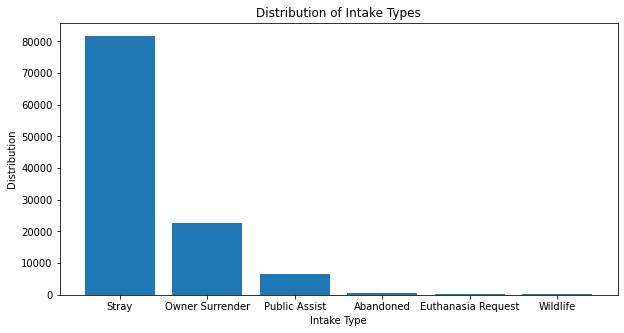

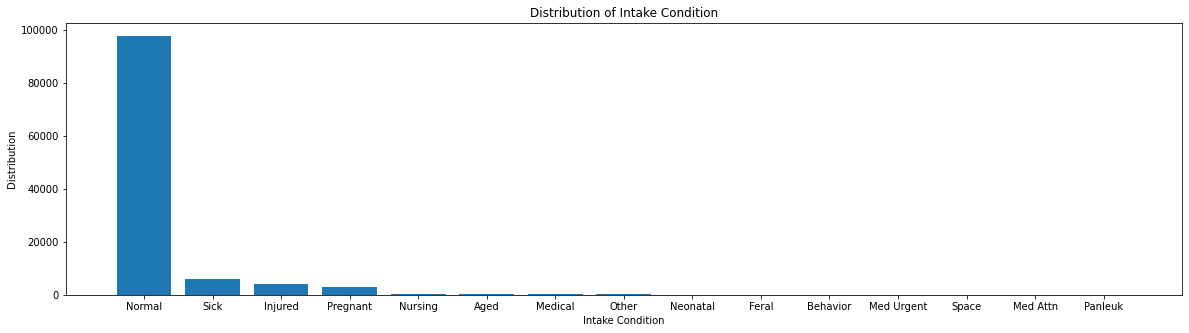

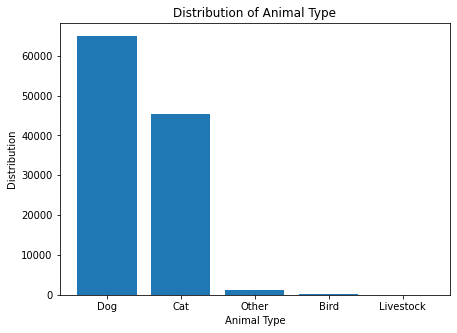

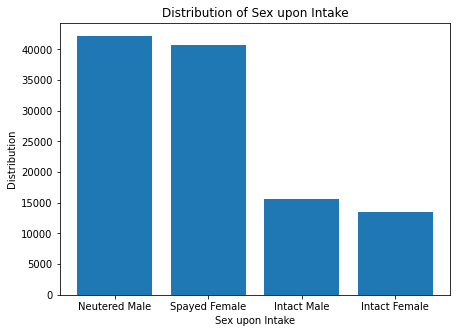

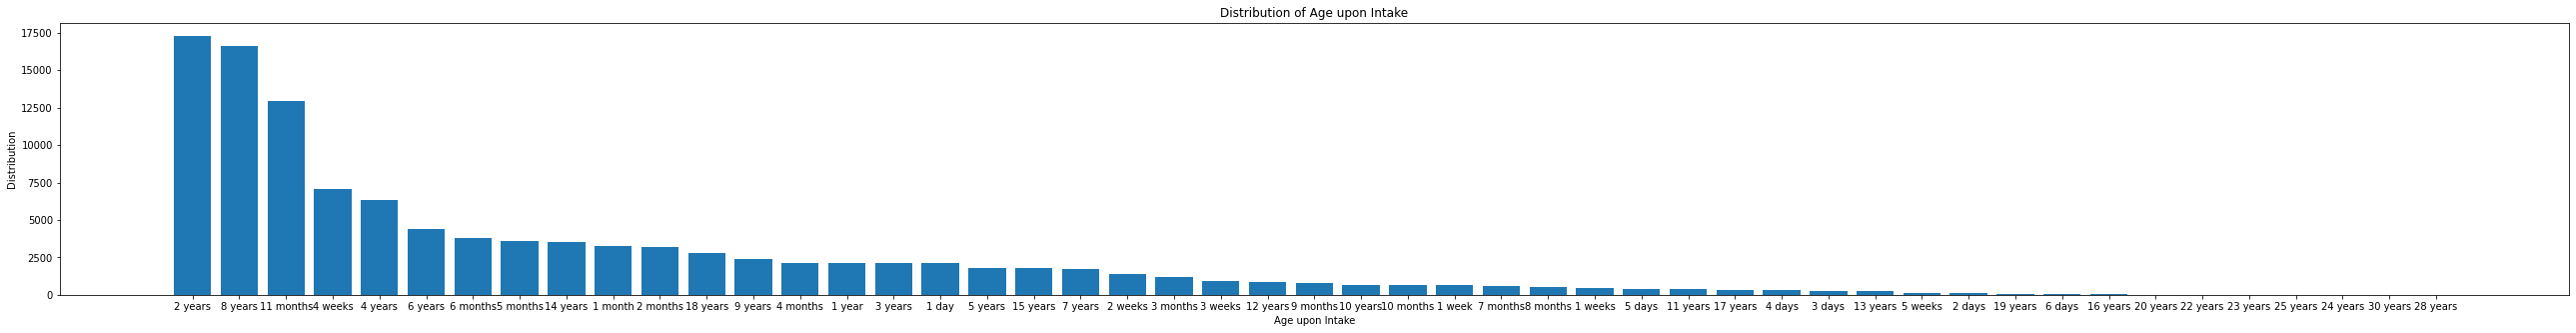

In [16]:
# Intake Type
fig = plt.figure(figsize = (10, 5)) 
plt.bar(intakes_df['Intake Type'].unique(), intakes_df['Intake Type'].value_counts().values)
plt.title('Distribution of Intake Types')
plt.xlabel('Intake Type')
plt.ylabel('Distribution')

# Intake Condition
fig = plt.figure(figsize = (20, 5)) 
plt.bar(intakes_df['Intake Condition'].unique(), intakes_df['Intake Condition'].value_counts().values)
plt.title('Distribution of Intake Condition')
plt.xlabel('Intake Condition')
plt.ylabel('Distribution')

# Animal Type
fig = plt.figure(figsize = (7, 5)) 
plt.bar(intakes_df['Animal Type'].unique(), intakes_df['Animal Type'].value_counts().values)
plt.title('Distribution of Animal Type')
plt.xlabel('Animal Type')
plt.ylabel('Distribution')

# Sex upon Intake
fig = plt.figure(figsize = (7, 5)) 
plt.bar(intakes_df['Sex upon Intake'].unique(), intakes_df['Sex upon Intake'].value_counts().values)
plt.title('Distribution of Sex upon Intake')
plt.xlabel('Sex upon Intake')
plt.ylabel('Distribution')

# Age upon Intake
fig = plt.figure(figsize = (45, 5)) 
plt.bar(intakes_df['Age upon Intake'].unique(), intakes_df['Age upon Intake'].value_counts().values)
plt.title('Distribution of Age upon Intake')
plt.xlabel('Age upon Intake')
plt.ylabel('Distribution')

In [17]:
# Showing value counts only for these features because a bar graph
# was not legible due to the availability of multitudes of values per feature
print('Value counts of Breed')
print(intakes_df['Breed'].value_counts())
print()
print('Value counts of Color')
print(intakes_df['Color'].value_counts())

Value counts of Breed
Domestic Shorthair Mix               27432
Domestic Shorthair                    9675
Pit Bull Mix                          6786
Labrador Retriever Mix                6132
Chihuahua Shorthair Mix               5723
                                     ...  
Border Collie/English Pointer            1
Akita/Pit Bull                           1
German Shorthair Pointer/Brittany        1
Chihuahua Shorthair/Cirneco              1
Munchkin Longhair                        1
Name: Breed, Length: 2669, dtype: int64

Value counts of Color
Black/White          11774
Black                 9389
Brown Tabby           6871
White                 4062
Brown/White           3763
                     ...  
Brown Merle/Gray         1
Tricolor/Orange          1
Calico/Gray Tabby        1
Lynx Point/Blue          1
Brown Tabby/Tan          1
Name: Color, Length: 594, dtype: int64


#### Outcomes Data

Text(0, 0.5, 'Distribution')

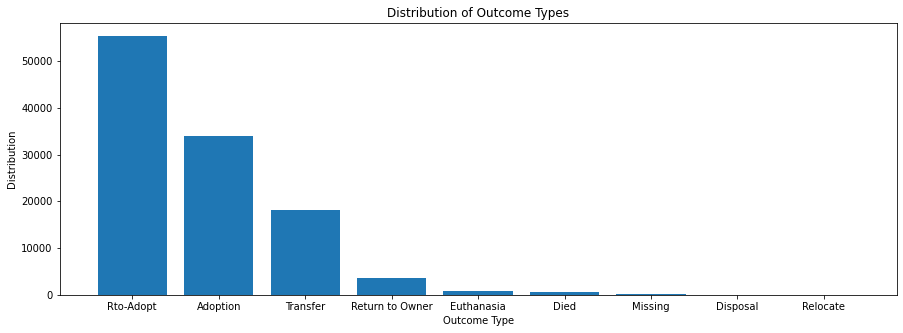

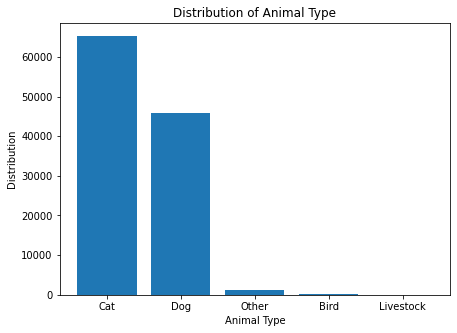

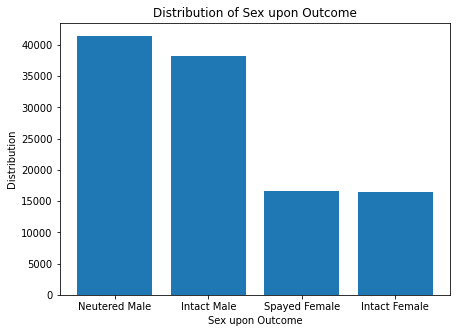

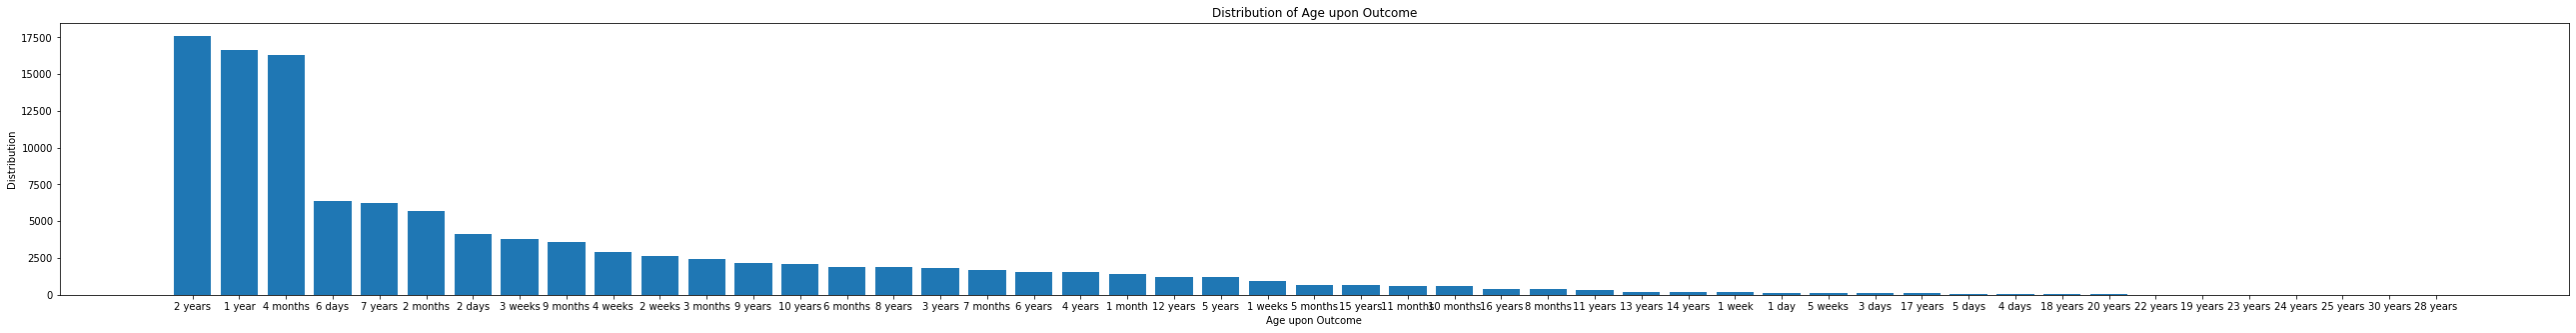

In [18]:
# Outcome Type
fig = plt.figure(figsize = (15, 5)) 
plt.bar(outcomes_df['Outcome Type'].unique(), outcomes_df['Outcome Type'].value_counts().values)
plt.title('Distribution of Outcome Types')
plt.xlabel('Outcome Type')
plt.ylabel('Distribution')

# Animal Type
fig = plt.figure(figsize = (7, 5)) 
plt.bar(outcomes_df['Animal Type'].unique(), outcomes_df['Animal Type'].value_counts().values)
plt.title('Distribution of Animal Type')
plt.xlabel('Animal Type')
plt.ylabel('Distribution')

# Sex upon Outcome
fig = plt.figure(figsize = (7, 5)) 
plt.bar(outcomes_df['Sex upon Outcome'].unique(), outcomes_df['Sex upon Outcome'].value_counts().values)
plt.title('Distribution of Sex upon Outcome')
plt.xlabel('Sex upon Outcome')
plt.ylabel('Distribution')

# Age upon Outcome
fig = plt.figure(figsize = (45, 5)) 
plt.bar(outcomes_df['Age upon Outcome'].unique(), outcomes_df['Age upon Outcome'].value_counts().values)
plt.title('Distribution of Age upon Outcome')
plt.xlabel('Age upon Outcome')
plt.ylabel('Distribution')

In [19]:
# Showing value counts only for these features because a bar graph
# was not legible due to the availability of multitudes of values per feature
print('Value counts of Breed')
print(outcomes_df['Breed'].value_counts())
print()
print('Value counts of Color')
print(outcomes_df['Color'].value_counts())

Value counts of Breed
Domestic Shorthair Mix              27893
Domestic Shorthair                   9603
Pit Bull Mix                         6848
Labrador Retriever Mix               6182
Chihuahua Shorthair Mix              5799
                                    ...  
Bullmastiff/Boxer                       1
Rat Terrier/English Pointer             1
Norwegian Elkhound/Alaskan Husky        1
Shih Tzu/Cavalier Span                  1
Munchkin Longhair                       1
Name: Breed, Length: 2679, dtype: int64

Value counts of Color
Black/White        11886
Black               9494
Brown Tabby         6923
White               4086
Brown/White         3784
                   ...  
Blue Tabby/Buff        1
Chocolate/Gold         1
Torbie/Calico          1
Yellow/Red             1
Orange/Tricolor        1
Name: Color, Length: 598, dtype: int64


### Analysis

In [20]:
outcomes_df['Outcome Type'].unique()

array(['Rto-Adopt', 'Adoption', 'Transfer', 'Return to Owner',
       'Euthanasia', 'Died', 'Missing', 'Disposal', 'Relocate'],
      dtype=object)

We can see that there are many reasons an animal may be taken into Austin Animal Center along with many intake conditions etc. Dogs and cats are the most common types of animals taken in, with the most common reason for intake being stray, surrendered by their owner, or a public assist. Most animals are taken in normal conditions. Many are neutered or spayed. 

Given these trends, we formulate the following hypotheses:

- The type of animal plays a role into whether an animal will be adopted or not
- Age plays a role into whether an animal will be adopted or not
- Breed plays a role into whether an animal will be adopted or not
- Color plays a role into whether an animal will be adopted or not
- The health (i.e. the intake condition) of an animal will play a role into whether that animal will be adopted or not
- The time of the year (i.e. the month) plays a role into whether an animal will be adopted or not

We now analyze these relationships and test our hypotheses. Please note that we explicitly focus on the outcome of adoption only, even though there are other outcomes possible, for the purposes of data exploration. This is done in the interest of space and cociseness, and also because our main focus is to predict whether an animal will be adopted or not. 

_Note: We present the analysis for both Adoption and Rto-Adoption separately, instead of aggregating them together, for clarity and a better understanding of adoption trends. However, it should be kept in mind that both are a form of adoption. Rto-Adoption is simply the case where the animal goes back to its original owners first and then is adopted by someone else. We will aggregate these two outcomes when we build our models._

#### Relation of Animal Type and Adoption

In [21]:
df_adoption = outcomes_df[outcomes_df['Outcome Type'] == 'Adoption']
df_rto_adoption = outcomes_df[outcomes_df['Outcome Type'] == 'Rto-Adopt']

Text(0, 0.5, 'Ratio')

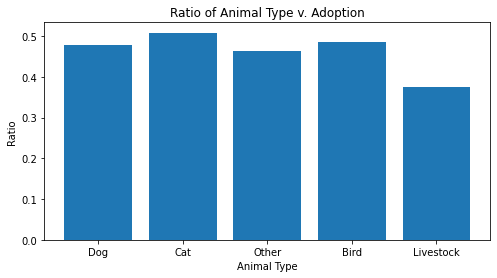

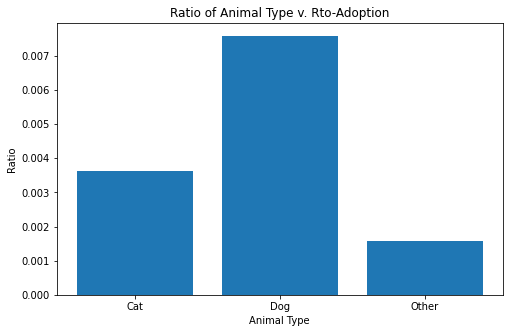

In [22]:
fig = plt.figure(figsize = (8, 4)) 
vals = df_adoption['Animal Type'].value_counts() / outcomes_df['Animal Type'].value_counts()
plt.bar(df_adoption['Animal Type'].unique(), vals.values)
plt.title('Ratio of Animal Type v. Adoption')
plt.xlabel('Animal Type')
plt.ylabel('Ratio')

fig = plt.figure(figsize = (8, 5)) 
vals = (df_rto_adoption['Animal Type'].value_counts() / outcomes_df['Animal Type'].value_counts()).dropna()
plt.bar(df_rto_adoption['Animal Type'].unique(), vals.values)
plt.title('Ratio of Animal Type v. Rto-Adoption')
plt.xlabel('Animal Type')
plt.ylabel('Ratio')

The type of animal plays a role to some degree into whether the animal will be adopted or not. It seems that cats have a slighlty higher chance than dogs to be adopted. However, their chances signiicantly reduce when it comes down to Rto-Adoption. Birds and dogs have about the same chance of being adopted. Note, however, that Birds have no change of being Rto-Adopt since they did not even show up in the second graph (this is likely a bias in the data, however). The same is true for Livestock. Livestock also have a significantly lower chance of being adopted. 

#### Relation of Age and Adoption

In [23]:
def process_age(age):
  if 'month' in age:
    return '0-1 year'
  if 'week' in age:
    return '0-1 year'
  if 'year' in age:
    return age
  if 'day' in age:
    return '0-1 year'
  return age

Text(0, 0.5, 'Ratio')

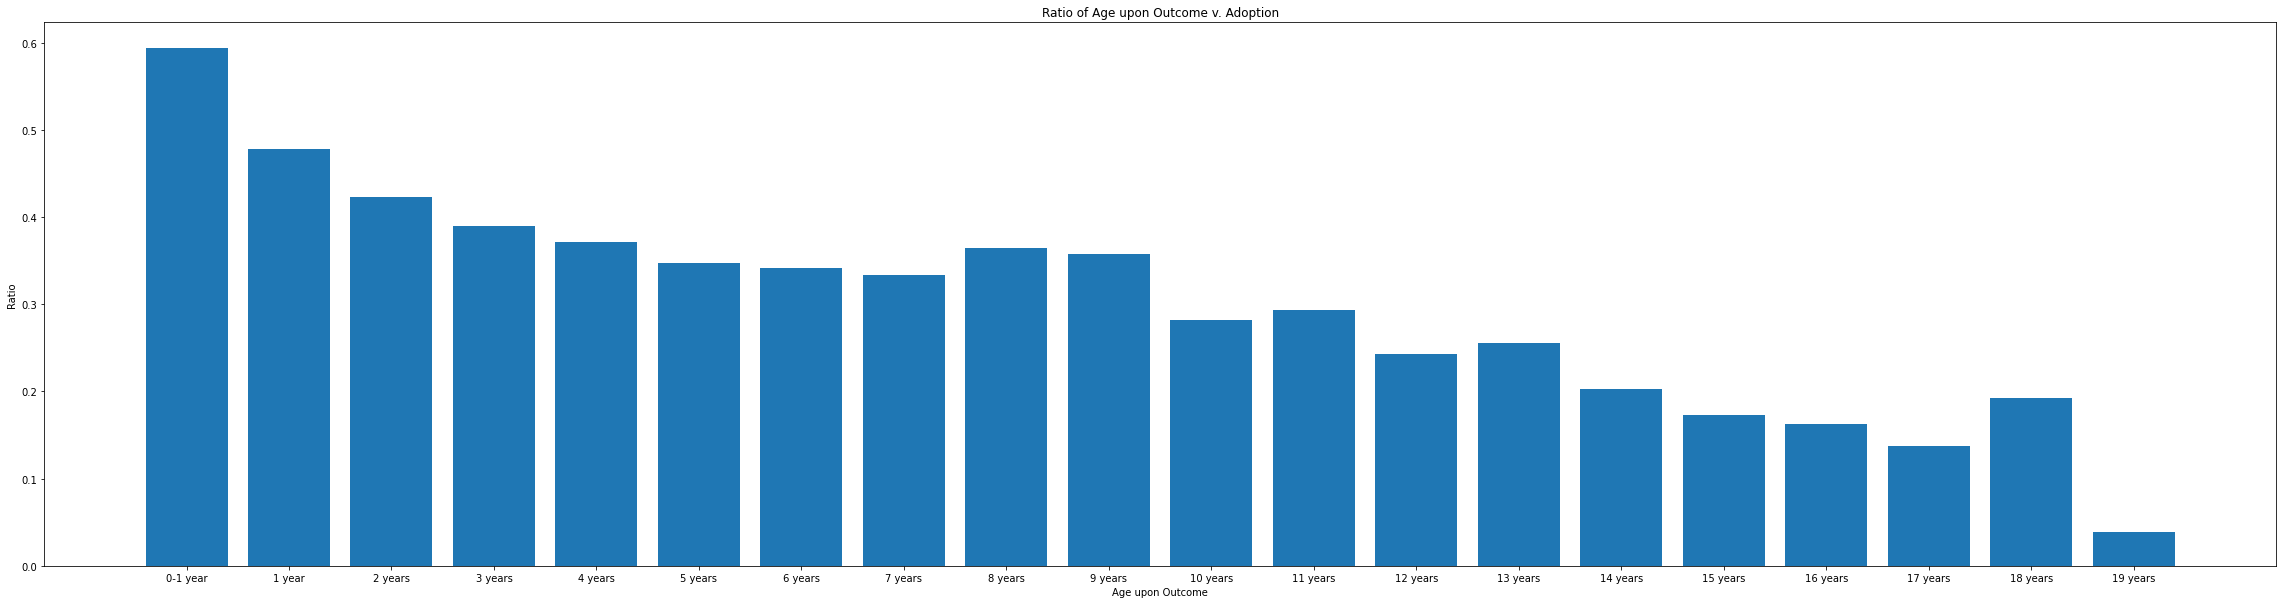

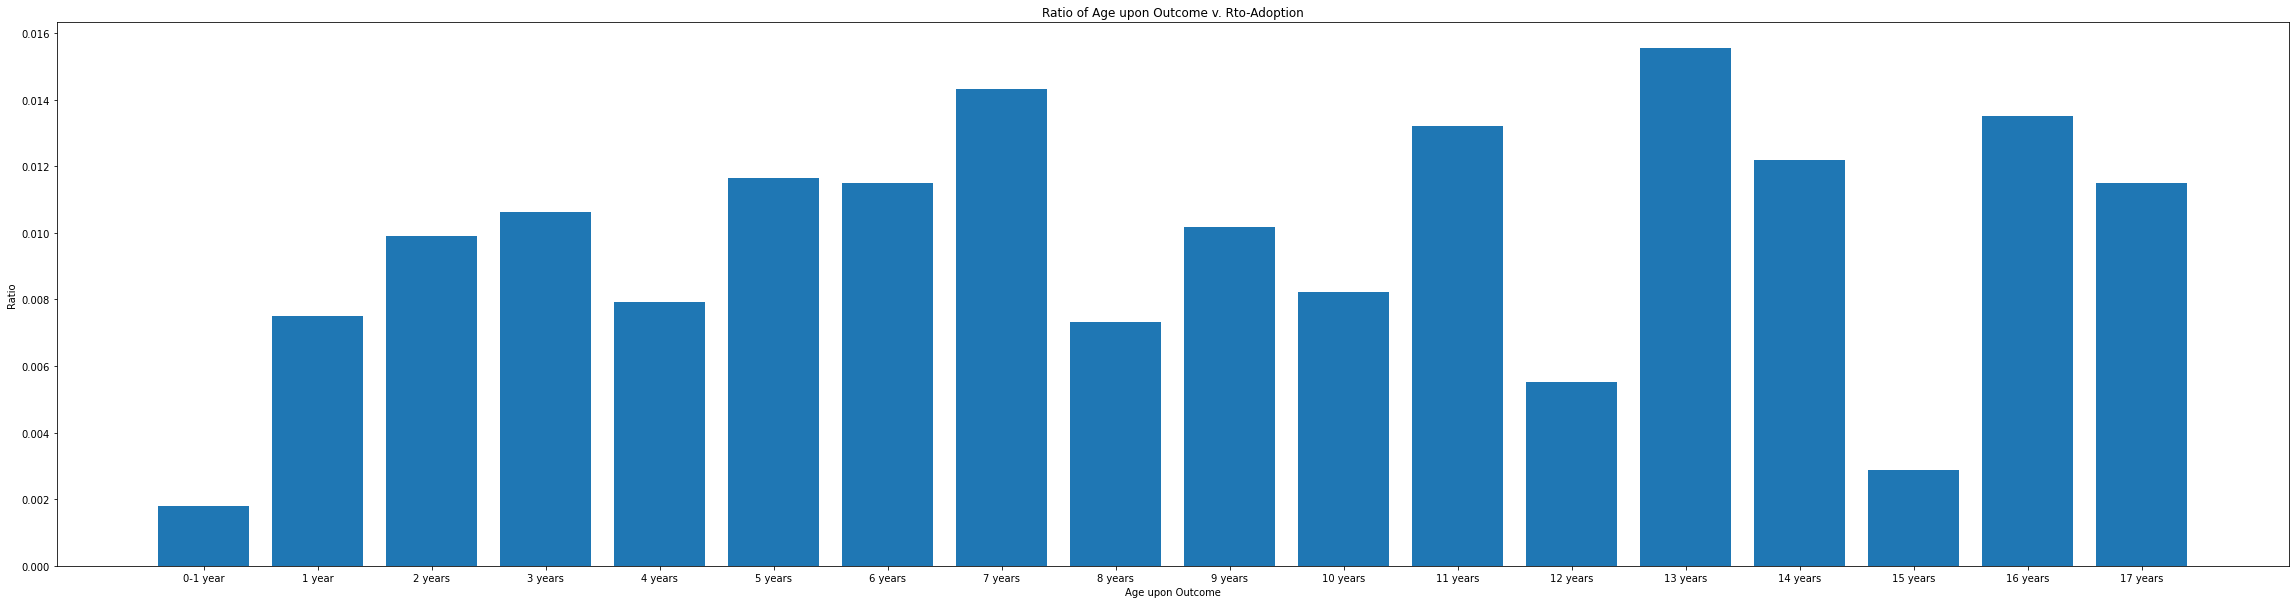

In [24]:
ages = ['0-1 year', '1 year', '2 years', '3 years', '4 years', 
         '5 years', '6 years', '7 years', '8 years', '9 years', 
         '10 years', '11 years', '12 years', '13 years', '14 years', 
         '15 years', '16 years', '17 years', '18 years', '19 years']
df = outcomes_df.copy()
df['Age upon Outcome'] = df['Age upon Outcome'].apply(lambda x: process_age(x))

df_a = df[df['Outcome Type'] == 'Adoption']
df_ra = df[df['Outcome Type'] == 'Rto-Adopt']

vals = (df_a['Age upon Outcome'].value_counts() / df['Age upon Outcome'].value_counts()).dropna()
counts = []
for age in ages: counts.append(vals[age])
d = pd.DataFrame(dict(age=ages,count=counts))
fig = plt.figure(figsize = (40, 10)) 
plt.bar('age', 'count', data=d)
plt.title('Ratio of Age upon Outcome v. Adoption')
plt.xlabel('Age upon Outcome')
plt.ylabel('Ratio')

vals = (df_ra['Age upon Outcome'].value_counts() / df['Age upon Outcome'].value_counts()).dropna()
counts = []
for i in range(len(ages)-2): counts.append(vals[ages[i]])
d = pd.DataFrame(dict(age=ages[0:len(ages)-2],count=counts))
fig = plt.figure(figsize = (40, 10)) 
plt.bar('age', 'count', data=d)
plt.title('Ratio of Age upon Outcome v. Rto-Adoption')
plt.xlabel('Age upon Outcome')
plt.ylabel('Ratio')

A relationship between age and adoption is obvoius - younger animals tend to get adopted more than older animals. However, the same pattern does not hold true for rto-adoption. In fact, it seems that older animals go through rto-adoption more. However, this trend is quite loose in rto-adoption, and an exact relationship between rto-adoption and age is harder to discern. We will leave this task to the models we build later. 

#### Relation of Breed and Adoption

In [25]:
vals = (df_adoption['Breed'].value_counts() / outcomes_df['Breed'].value_counts()).dropna()
print('Ratio of Breed v. Adoption')
print(vals)
print()
vals = (df_rto_adoption['Breed'].value_counts() / outcomes_df['Breed'].value_counts()).dropna()
print('Ratio of Breed v. Rto-Adoption')
print(vals)

Ratio of Breed v. Adoption
Abyssinian                                       0.571429
Abyssinian Mix                                   0.600000
Affenpinscher                                    1.000000
Affenpinscher Mix                                0.571429
Afghan Hound/Labrador Retriever                  1.000000
                                                   ...   
Yorkshire Terrier/Shih Tzu                       0.666667
Yorkshire Terrier/Soft Coated Wheaten Terrier    1.000000
Yorkshire Terrier/Standard Schnauzer             1.000000
Yorkshire Terrier/Toy Poodle                     0.363636
Yorkshire Terrier/Yorkshire Terrier              1.000000
Name: Breed, Length: 1936, dtype: float64

Ratio of Breed v. Rto-Adoption
Akita                                    0.050000
Akita Mix                                0.040000
Alaskan Husky                            0.023529
Alaskan Husky Mix                        0.024000
Alaskan Malamute                         0.055556
           

While we are not able to effectively display this data in a graph, a simple inspection of the ratios above clearly shows that the breed of an animal does play a role into its chances of being adopted or rto-adopted.

#### Relation of Color and Adoption

In [26]:
vals = (df_adoption['Color'].value_counts() / outcomes_df['Color'].value_counts()).dropna()
print('Ratio of Color v. Adoption')
print(vals)
print()
vals = (df_rto_adoption['Color'].value_counts() / outcomes_df['Color'].value_counts()).dropna()
print('Ratio of Color v. Rto-Adoption')
print(vals)

Ratio of Color v. Adoption
Agouti                0.625000
Agouti/Brown Tabby    1.000000
Agouti/Gray           1.000000
Agouti/White          0.666667
Apricot               0.452055
                        ...   
Yellow/Cream          1.000000
Yellow/Orange         0.500000
Yellow/Red            1.000000
Yellow/Tan            0.250000
Yellow/White          0.460432
Name: Color, Length: 454, dtype: float64

Ratio of Color v. Rto-Adoption
Apricot                 0.013699
Black                   0.004319
Black Smoke/Gray        1.000000
Black Smoke/White       0.020408
Black/Black             0.006944
                          ...   
White/Tan               0.007506
White/Tricolor          0.007380
White/White             0.020619
White/Yellow Brindle    0.166667
Yellow                  0.003241
Name: Color, Length: 96, dtype: float64


Once again, while we are not able to effectively display this data in a graph, a simple inspection of the ratios above clearly shows that the color of an animal does play a role into its chances of being adopted or rto-adopted.

#### Relation of Intake Condition (Health) and Adoption

To relate Intake Health with Adoption, we must first merge `intakes_df` and `outcomes_df`. Note that we will once again to this later after feature engineering. Thus, this merge is only for this analysis.

In [27]:
merged = intakes_df.merge(outcomes_df[[ 'Animal ID', 'MonthYear', 'Outcome Type', 'Animal Type', 'Sex upon Outcome', 'Age upon Outcome', 'Breed', 'Color' ]], on='Animal ID')
merged_adoption = merged[merged['Outcome Type'] == 'Adoption']
merged_rto_adoption = merged[merged['Outcome Type'] == 'Rto-Adopt']

Text(0, 0.5, 'Ratio')

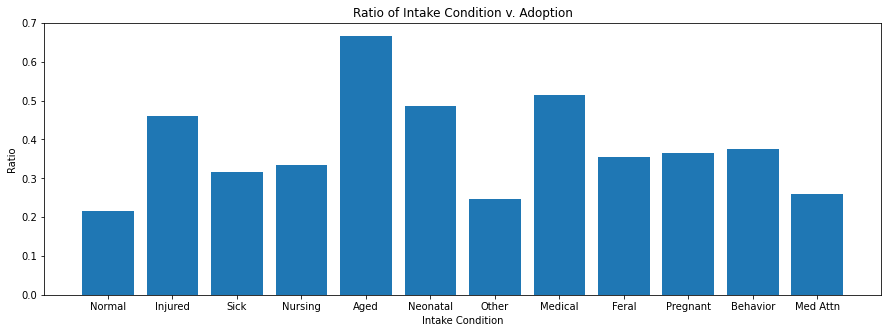

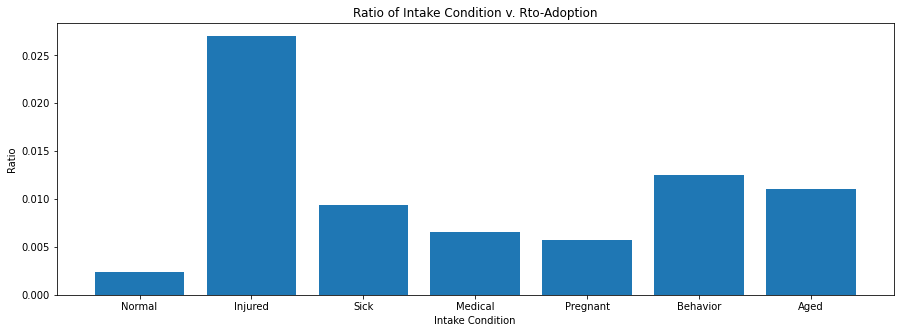

In [28]:
fig = plt.figure(figsize = (15, 5)) 
vals = (merged_adoption['Intake Condition'].value_counts() / merged['Intake Condition'].value_counts()).dropna()
plt.bar(merged_adoption['Intake Condition'].unique(), vals.values)
plt.title('Ratio of Intake Condition v. Adoption')
plt.xlabel('Intake Condition')
plt.ylabel('Ratio')

fig = plt.figure(figsize = (15, 5)) 
vals = (merged_rto_adoption['Intake Condition'].value_counts() / merged['Intake Condition'].value_counts()).dropna()
plt.bar(merged_rto_adoption['Intake Condition'].unique(), vals.values)
plt.title('Ratio of Intake Condition v. Rto-Adoption')
plt.xlabel('Intake Condition')
plt.ylabel('Ratio')

Observing the graphs above clearly shows that the intake health of an animal impacts its chances to get adopted or rto-adopted. However, finding an apparent patterns between the specific intake condition and chances of adoption (or rto-adoption) are much harder to discern. We will leave this task to the models that we will make later on.

#### Relation of Time of Year (Month) and Adoption

In [29]:
merged['Outcome Month'] = merged['MonthYear'].apply(lambda x: x.split(' ')[0])
merged_adoption = merged[merged['Outcome Type'] == 'Adoption']
merged_rto_adoption = merged[merged['Outcome Type'] == 'Rto-Adopt']

Text(0, 0.5, 'Distribution')

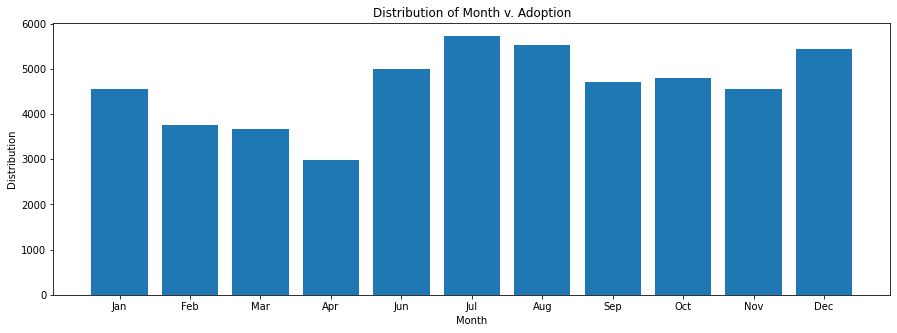

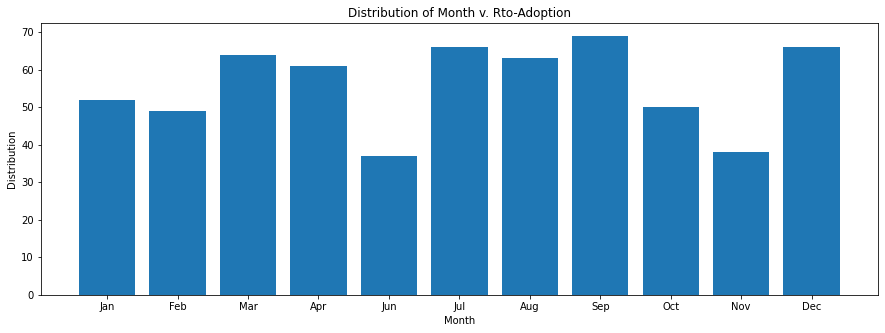

In [30]:
cols = ['Jan', 'Feb', 'Mar', 'Apr', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig = plt.figure(figsize = (15, 5)) 
value_counts = merged_adoption['Outcome Month'].value_counts()
counts = []
for key in cols: counts.append(value_counts[key])
vals = pd.DataFrame(dict(month=cols,count=counts))
plt.bar('month', 'count', data=vals)
plt.title('Distribution of Month v. Adoption')
plt.xlabel('Month')
plt.ylabel('Distribution')

fig = plt.figure(figsize = (15, 5)) 
value_counts = merged_rto_adoption['Outcome Month'].value_counts()
counts = []
for key in cols: counts.append(value_counts[key])
vals = pd.DataFrame(dict(month=cols,count=counts))
plt.bar('month', 'count', data=vals)
plt.title('Distribution of Month v. Rto-Adoption')
plt.xlabel('Month')
plt.ylabel('Distribution')

The graphs above clearly show a realtionship between the time of the year and adoption. It seems that people prefer to adopt when the weather is a little warmer and nicer (probably so that people can take with their new pet outside). 

There also seems to be a relationship between the time of the year and rto-adoption. Similar patterns as above hold, but much more loosely. Discerning a stronger pattern, or reasoning for such a pattern, is more difficult. We leave such inferences to the models that we will develop later. 

### Final thoughts on data exploration

Our analyses above clearly show that features such as intake condition and age of an animal impacts its ability to get adopted or rto-adopted. Hence, the features analyzed above will be crucial as the input to our models.

It is important to note that adoption and rto-adoption are not the only possible outcomes. We did not analyze the relation of above features compared to other outcome types in the interest of conciseness - however, that is not to say that a relationship does not exist. We, however, are going to focus on adoption v. no adoption only for the purposes of this project. We hope that future projects find our work useful and can augment it even further to include other outcomes such as a transfer, etc. 

## Feature Engineering and Final Data Prep

From the output below, we see that all our data is currently an object type, or categorical. However, some features should be continuous while others should be categorical. We convert the appropriate features into continuous variables first and then perform one hot encoding to the remaining categorical features.

In [31]:
print('intakes_df.info()')
print(intakes_df.info())
print()
print('outcomes_df.info()')
print(outcomes_df.info())

intakes_df.info()
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112006 entries, 0 to 138349
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Animal ID         112006 non-null  object
 1   Intake Type       112006 non-null  object
 2   Intake Condition  112006 non-null  object
 3   Animal Type       112006 non-null  object
 4   Sex upon Intake   112006 non-null  object
 5   Age upon Intake   112006 non-null  object
 6   Breed             112006 non-null  object
 7   Color             112006 non-null  object
dtypes: object(8)
memory usage: 7.7+ MB
None

outcomes_df.info()
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112779 entries, 0 to 138564
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Animal ID         112779 non-null  object
 1   MonthYear         112779 non-null  object
 2   Outcome Type      112779 non-null 

We convert `Age upon Intake` and `Age upon Outcome` features in `intakes_df` and `outcomes_df` to continuous features by casting them to a number. We also create a new feature, `Outcome Month`, from splitting up the existing `MonthYear` feature. This will help our classifier better grasp the realtionship between the time of the year (i.e. month) and adoption.

In [32]:
def standardize_age(age):
  if 'month' in age:
    return 0
  if 'year' in age:
    return int(age.split(' ')[0])
  if 'day' in age:
    return 0
  return 0

intakes_df['Intake Age (Years)'] = intakes_df['Age upon Intake'].apply(lambda x: standardize_age(x))
intakes_df = intakes_df.drop(columns=['Age upon Intake'])

outcomes_df['Outcome Age (Years)'] = outcomes_df['Age upon Outcome'].apply(lambda x: standardize_age(x))
outcomes_df['Outcome Month'] = outcomes_df['MonthYear'].apply(lambda x: x.split(' ')[0])
outcomes_df['Outcome Month'] = outcomes_df['Outcome Month'].map(lambda x: ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'].index(x) + 1)
outcomes_df = outcomes_df.drop(columns=['Age upon Outcome', 'MonthYear'])

Before dealing with the categorical features, we combine `intakes_df` and `outcomes_df` on `Animal ID` to get our merged dataset. We will drop `Animal ID` because it will not be useful to us for the task of classfication.

In [33]:
# Combine together into singular dataframe
data = intakes_df.merge(outcomes_df[['Animal ID', 'Outcome Type', 'Sex upon Outcome', 'Outcome Age (Years)', 'Outcome Month']], on='Animal ID')
data = data.drop('Animal ID', axis=1)
data.head()

,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Breed,Color,Intake Age (Years),Outcome Type,Sex upon Outcome,Outcome Age (Years),Outcome Month
0,Stray,Normal,Dog,Neutered Male,Beagle Mix,Tricolor,2,Transfer,Neutered Male,2,1
1,Stray,Normal,Dog,Spayed Female,English Springer Spaniel,White/Liver,8,Return to Owner,Spayed Female,8,7
2,Stray,Normal,Dog,Intact Male,Basenji Mix,Sable/White,0,Return to Owner,Neutered Male,1,4
3,Stray,Sick,Cat,Intact Female,Domestic Shorthair Mix,Calico,0,Transfer,Intact Female,0,10
4,Stray,Normal,Dog,Neutered Male,Doberman Pinsch/Australian Cattle Dog,Tan/Gray,4,Return to Owner,Neutered Male,4,7


Before dealing with the categorical vaiables, we have one more thing we must do. From our data exploration earlier, you might have noticed something interesting. There is quite a class imbalance with in our dataset. If we use the original outcomes dataset, we notice that some classes have thousands of data points associated with them while other have only a couple hundred. The classes `Disposal`, `Missing`, and `Relocate` especially don't much data associated with them. Because our main goal is to build classifiers that are able to accurately predict if an animal will be adopted or not, and because the number of data points in `Disposal`, `Missing`, and `Relocate` classes is quite dismal (which would mean that our algorithm would not learn much about these classes, and even oversampling would not produce very good results), we are going to drop these features.


This will not solve our problem of class imbalances still. Therefore, we will use SMOTE to solve class imbalances later when we develop our models

Text(0, 0.5, 'Distribution')

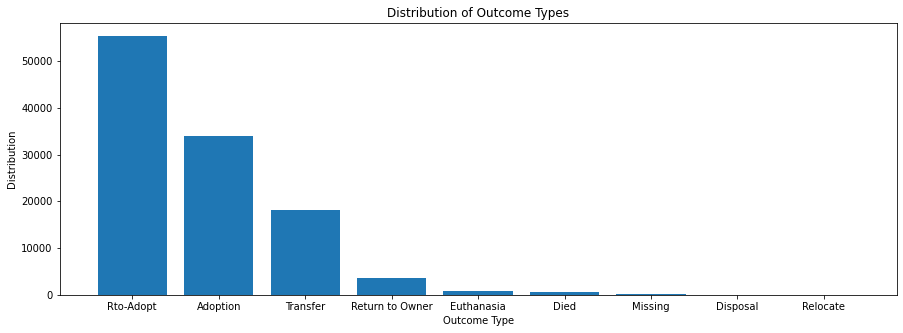

In [34]:
fig = plt.figure(figsize = (15, 5)) 
plt.bar(outcomes_original['Outcome Type'].unique(), outcomes_original['Outcome Type'].value_counts().values)
plt.title('Distribution of Outcome Types')
plt.xlabel('Outcome Type')
plt.ylabel('Distribution')

In [35]:
indices = (data['Outcome Type'] == 'Disposal')
indices = indices.index[indices == True].tolist()
data.drop(indices, inplace=True)

indices = (data['Outcome Type'] == 'Missing')
indices = indices.index[indices == True].tolist()
data.drop(indices, inplace=True)

indices = (data['Outcome Type'] == 'Relocate')
indices = indices.index[indices == True].tolist()
data.drop(indices, inplace=True)

data = data.reset_index(drop=True)
data['Outcome Type'].unique() # shows that Disposal, Missing, and Relocate have been dropped

array(['Transfer', 'Return to Owner', 'Adoption', 'Euthanasia', 'Died',
       'Rto-Adopt'], dtype=object)

We also noticed, during data exploration, that there are quite a few values for `Breed` and `Color`. While analyzing such a value count may be advantageous in select situation, it will not be of much use for generalizability. Furthermore, we are also limited in our compute power. Thus, we perform an operation akin to imputation to bring such a large value count to a much more manageable number. Besides `Outcome Type`, we check the count of each specific value per feature, and if the count is less than 1100 (a number we came to after trial and error), we resplace that value with the mode all values for that feature.

In [36]:
# Imputation
for column in list(data.columns):
    if column == 'Outcome Type':
        continue
    column_counts = data[column].value_counts().to_frame()
    ignored_type = column_counts[column_counts[column] < 1100]
    ignored_type_arr = ignored_type.index.values.tolist()
    data[column].replace(to_replace=ignored_type_arr, value=np.NAN, inplace=True)
    data[column].fillna(data[column].mode().values[0], inplace=True)
data

,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Breed,Color,Intake Age (Years),Outcome Type,Sex upon Outcome,Outcome Age (Years),Outcome Month
0,Stray,Normal,Dog,Neutered Male,Domestic Shorthair Mix,Tricolor,2.0,Transfer,Neutered Male,2.0,1
1,Stray,Normal,Dog,Spayed Female,Domestic Shorthair Mix,Black/White,8.0,Return to Owner,Spayed Female,8.0,7
2,Stray,Normal,Dog,Intact Male,Domestic Shorthair Mix,Black/White,0.0,Return to Owner,Neutered Male,1.0,4
3,Stray,Sick,Cat,Intact Female,Domestic Shorthair Mix,Calico,0.0,Transfer,Intact Female,0.0,10
4,Stray,Normal,Dog,Neutered Male,Domestic Shorthair Mix,Black/White,4.0,Return to Owner,Neutered Male,4.0,7
...,...,...,...,...,...,...,...,...,...,...,...
111263,Owner Surrender,Normal,Dog,Intact Male,Domestic Shorthair Mix,Brown/Black,0.0,Adoption,Neutered Male,0.0,4
111264,Owner Surrender,Normal,Cat,Spayed Female,Siamese Mix,Black/White,7.0,Adoption,Spayed Female,0.0,12
111265,Owner Surrender,Normal,Dog,Spayed Female,Domestic Shorthair Mix,Blue/White,4.0,Adoption,Spayed Female,4.0,1
111266,Public Assist,Normal,Dog,Spayed Female,Domestic Shorthair Mix,Black/White,2.0,Transfer,Spayed Female,2.0,8


Finally, we will process the categorical features. `Intake Type`, `Intake Condition`, `Animal Type`, `Sex upon Intake`, `Animal Type`, `Sex upon Outcome`, `Breed`, and `Color` are all categorial features. We use one hot encoding on these features so that our classifiers can use them features appropriately. While `Outcome Type` is also a categorical feature, we will separate it from our dataset to serve as labels only. Furthermore, we will convert all outcome types to adoption or no adoption for the purposes of this project (our aim is binary classification, to predict whether an animal in the Austin Animal Center will be adopted or not). `Adoption` and `Rto-Adopt` are considered `Adoption`; all other outcomes are considered `No Adoption`.

In [37]:
# Store the original labels, in case they are useful in the future
original_labels = data['Outcome Type'].copy()

In [38]:
# Separating lablels and features
labels = data['Outcome Type'].copy()
labels.replace(to_replace={'Rto-Adopt': 'Adoption', 'Transfer' : 'No Adoption', 'Return to Owner': 'No Adoption', 'Euthanasia': 'No Adoption', 'Died' : 'No Adoption'}, inplace=True)
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = pd.Series(labels)
print('Counts of each label')
print(labels.value_counts())

features_categorical = data.drop(columns=['Outcome Type', 'Intake Age (Years)', 'Outcome Age (Years)', 'Outcome Month'])
categorical_vars = features_categorical.copy()
categorical_vars_cols = categorical_vars.columns

features_continuous = data.drop(columns=['Intake Type', 'Intake Condition', 'Animal Type', 'Sex upon Intake', 'Breed', 'Color', 'Outcome Type','Sex upon Outcome'])

# One hot encoding the categorical features
one_hot_encoder = OneHotEncoder(sparse=False)
categorical_vars = one_hot_encoder.fit_transform(categorical_vars)
categorical_vars_cols = one_hot_encoder.get_feature_names(categorical_vars_cols)
data = pd.DataFrame(data=categorical_vars, columns=categorical_vars_cols)
data = pd.concat([data, features_continuous], axis=1)

print(labels.shape)
print(data.shape)
data.head()

Counts of each label
1    56073
0    55195
dtype: int64
(111268,)
(111268, 61)


/home/rohitn/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Intake Type_Owner Surrender,Intake Type_Public Assist,Intake Type_Stray,Intake Condition_Injured,Intake Condition_Normal,Intake Condition_Nursing,Intake Condition_Sick,Animal Type_Cat,Animal Type_Dog,Animal Type_Other,...,Color_White/Black,Color_White/Brown,Color_White/Tan,Sex upon Outcome_Intact Female,Sex upon Outcome_Intact Male,Sex upon Outcome_Neutered Male,Sex upon Outcome_Spayed Female,Intake Age (Years),Outcome Age (Years),Outcome Month
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,1
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,8.0,7
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,4.0,7


## Data Analysis and Modeling

Many different types of models were tested on our dataset. We, naturally, used supervised learning to fit models that predict whether an animal, that is taken in by the Austin Animal Center, will be adopted or not. It is important to understand that our model only predicts whether an animal will be adopted or not - it does not predict, or give any notion of, how long it will take before the animal is adopted. We first present our models and their results (test accuracy, classification report, and a confusion matrix). Thereafter, we present a comparison in the performance of all models.

_Note: We take a sample of 15000 randomly selected datapoints only for building our models in the interest of time and also due to the lack of compute power. Even then, we produce very good results with good accuracies. Of course, using more data could likely produce even higher accuracies._

In [39]:
# Take a sample of 15000 random data points
X = data.sample(frac=1).iloc[:15000]
y = labels.iloc[X.index]
X = X.reset_index(drop=True)

The following method is used for printing a confusion matrix and is adapted from a similar method that was provided by Dr. Beasley in Homework 2.

In [40]:
def print_confusion_matrix(mat):
    df = pd.DataFrame(mat, columns =['Predicted 1','Predicted 0'])
    df = df.rename(index={0: 'Actual 1', 1: 'Actual 0'})
    display(df)

### k-Nearest Neighbor Classifier

#### k-Nearest Neghbor Classifier with PCA

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', StandardScaler()],
                                ['pca', PCA()],
                                ['classifier', KNeighborsClassifier()]])
    
param_grid = {
    'pca__n_components': list(range(57, 61)),
    'classifier__n_neighbors': list(range(5, 15))
}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy')

test_score = cross_val_score(grid_search, X, y, cv=5).mean()
print(f'Test score: {test_score}')

Test score: 0.7686666666666666


In [42]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

preds = cross_val_predict(grid_search, X, y)
mat = confusion_matrix(y, preds)
print(classification_report(y, preds))
print('Confusion Matrix')
print_confusion_matrix(mat)

              precision    recall  f1-score   support

           0       0.74      0.82      0.78      7472
           1       0.80      0.72      0.76      7528

    accuracy                           0.77     15000
   macro avg       0.77      0.77      0.77     15000
weighted avg       0.77      0.77      0.77     15000

Confusion Matrix


,Predicted 1,Predicted 0
Actual 1,6137,1335
Actual 0,2135,5393


roc_auc_score: 0.7688625562354504


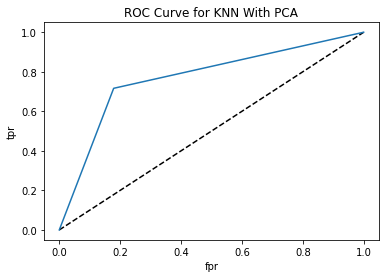

In [43]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, _ = roc_curve(y, preds)
print('roc_auc_score:', roc_auc_score(y, preds))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='AdaBoost')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for KNN With PCA')
plt.show()

PCA is really useful when dealing with a lot of continuous features. However, most of our features are categorical and one hot encoded, so it is possible that PCA actually does not do much for us. Hence, we run another iteration of KNN without PCA to compare results.

#### k-Nearest Neighbor Classifier without PCA

In [78]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', StandardScaler()],
                                ['classifier', KNeighborsClassifier()]])
    
param_grid = {
    'classifier__n_neighbors': list(range(5, 15))
}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy')

test_score = cross_val_score(grid_search, X, y, cv=5).mean()
print(f'Test score: {test_score}')

Test score: 0.7598


In [79]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

preds = cross_val_predict(grid_search, X, y)
mat = confusion_matrix(y, preds)
print(classification_report(y, preds))
print('Confusion Matrix')
print_confusion_matrix(mat)

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      7424
           1       0.79      0.72      0.75      7576

    accuracy                           0.76     15000
   macro avg       0.76      0.76      0.76     15000
weighted avg       0.76      0.76      0.76     15000

Confusion Matrix


,Predicted 1,Predicted 0
Actual 1,5969,1455
Actual 0,2148,5428


roc_auc_score: 0.7602435407411791


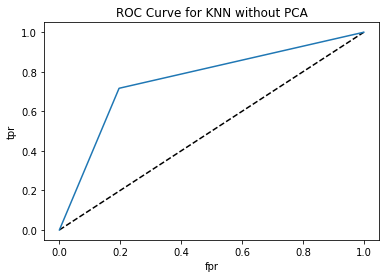

In [80]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, _ = roc_curve(y, preds)
print('roc_auc_score:', roc_auc_score(y, preds))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='KNN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for KNN without PCA')
plt.show()

Results are quite similar, whether PCA is involved or not. However, we can immedietly see that a k-Nearest Neighbor classifier will not be good enough and that another model will ned to be used to improve the accuracy.

### Ensemble Classifier: AdaBoost

In [73]:
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score

pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', StandardScaler()],
                                ['classifier', AdaBoostClassifier()]])
    
param_grid = {
    'classifier__n_estimators': list(range(146,151)),
}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy')

test_score = cross_val_score(grid_search, X, y, cv=5).mean()
print(f'Test score: {test_score}')

Test score: 0.8103333333333333


In [74]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

preds = cross_val_predict(grid_search, X, y)
mat = confusion_matrix(y, preds)
print(classification_report(y, preds))
print('Confusion Matrix')
print_confusion_matrix(mat)

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      7424
           1       0.83      0.79      0.81      7576

    accuracy                           0.81     15000
   macro avg       0.81      0.81      0.81     15000
weighted avg       0.81      0.81      0.81     15000

Confusion Matrix


,Predicted 1,Predicted 0
Actual 1,6182,1242
Actual 0,1603,5973


roc_auc_score: 0.8105577561173214


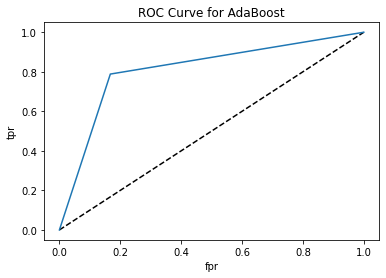

In [75]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, _ = roc_curve(y, preds)
print('roc_auc_score:', roc_auc_score(y, preds))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='AdaBoost')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for AdaBoost')
plt.show()

AdaBoost's accuracy is better and it is faster than the KNN classifier. It is a clear winner between the two.

### Support Vector Machine

Support vector machines (SVMs) can also benefit greatly when PCA is used on the dataset because it helps reduce the dimensionality of the dataset. We will, once again, try using them with and without PCA.  

#### SVM with PCA

In [81]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report


pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', StandardScaler()],
                                ['pca', PCA()],
                                ['classifier', SVC()]])

param_grid = {
    'pca__n_components': list(range(57, 61)),
    'classifier__kernel': ['linear', 'rbf', 'poly']
}

search = GridSearchCV(pipeline, param_grid, cv=5)
nested_score = cross_val_score(search, X, y, cv=5).mean()
print(f'Test score: {nested_score}')

preds = cross_val_predict(search, X, y)
mat = confusion_matrix(y, preds)
print(classification_report(y, preds))
print('Confusion Matrix')
print_confusion_matrix(mat)

Test score: 0.8170666666666666
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      7424
           1       0.84      0.78      0.81      7576

    accuracy                           0.82     15000
   macro avg       0.82      0.82      0.82     15000
weighted avg       0.82      0.82      0.82     15000

Confusion Matrix


,Predicted 1,Predicted 0
Actual 1,6332,1092
Actual 0,1652,5924


roc_auc_score: 0.8174262302916652


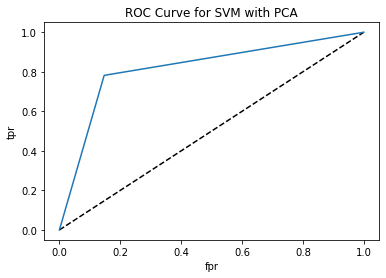

In [82]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, _ = roc_curve(y, preds)
print('roc_auc_score:', roc_auc_score(y, preds))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='SVM')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for SVM with PCA')
plt.show()

#### SVM without PCA

In [76]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report


pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', StandardScaler()],
                                ['classifier', SVC()]])

param_grid = {
    'classifier__kernel': ['linear', 'rbf', 'poly']
}

search = GridSearchCV(pipeline, param_grid, cv=5)
nested_score = cross_val_score(search, X, y, cv=5).mean()
print(f'Test score: {nested_score}')

preds = cross_val_predict(search, X, y)
mat = confusion_matrix(y, preds)
print(classification_report(y, preds))
print('Confusion Matrix')
print_confusion_matrix(mat)

Test score: 0.8170666666666666
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      7424
           1       0.84      0.78      0.81      7576

    accuracy                           0.82     15000
   macro avg       0.82      0.82      0.82     15000
weighted avg       0.82      0.82      0.82     15000

Confusion Matrix


,Predicted 1,Predicted 0
Actual 1,6332,1092
Actual 0,1652,5924


roc_auc_score: 0.8174262302916652


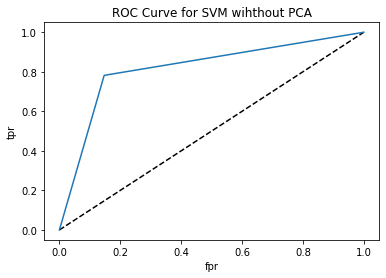

In [77]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, _ = roc_curve(y, preds)
print('roc_auc_score:', roc_auc_score(y, preds))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='SVM')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for SVM wihthout PCA')
plt.show()

Once again, performance seems similar. Naturally, the lack of PCA made the performance of an SVM faster. 

### Decision Trees

In [46]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report


pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', StandardScaler()],
                                ['classifier', DecisionTreeClassifier()]])

param_grid = {
    'classifier__max_depth': [5,10,15,20],
    'classifier__max_features': [51,56,61],
    'classifier__min_samples_leaf': [5,10,15,20]
}

search = GridSearchCV(pipeline, param_grid, cv=5)
nested_score = cross_val_score(search, X, y, cv=5).mean()
print(f'Test score: {nested_score}')

Test score: 0.8178666666666666


In [47]:
preds = cross_val_predict(search, X, y)
mat = confusion_matrix(y, preds)
print(classification_report(y, preds))
print('Confusion Matrix')
print_confusion_matrix(mat)

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      7424
           1       0.85      0.77      0.81      7576

    accuracy                           0.82     15000
   macro avg       0.82      0.82      0.82     15000
weighted avg       0.82      0.82      0.82     15000

Confusion Matrix


,Predicted 1,Predicted 0
Actual 1,6401,1023
Actual 0,1705,5871


roc_auc_score: 0.8185754327413246


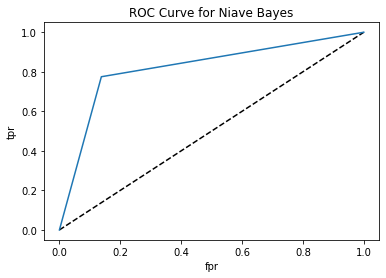

In [72]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, _ = roc_curve(y, preds)
print('roc_auc_score:', roc_auc_score(y, preds))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Decision Tree')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for Decision Tree')
plt.show()